# Chapter 13: Gas Reservoirs (The p/z Plot)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will estimate the **Initial Gas In Place (G)** using the classical **Material Balance Equation (MBE)** for a volumetric gas reservoir.

**The Theory:**
For a closed gas reservoir (no water influx, constant pore volume), the material balance equation is:

$$\frac{p}{z} = \frac{p_i}{z_i} \left( 1 - \frac{G_p}{G} \right)$$

This equation is a straight line ($y = mx + c$) if we plot:
* **y-axis:** $p/z$ (pressure corrected for gas deviation)
* **x-axis:** $G_p$ (cumulative gas production)

**Key Insights from the Plot:**
1.  **y-intercept:** Represents the initial state ($p_i/z_i$).
2.  **x-intercept:** Represents the point where pressure drops to zero. This value is **G** (Total Gas In Place).
3.  **Linearity:** If the data forms a straight line, the reservoir is volumetric. If it curves downward, there is a leak/interference. If it curves upward, there is water influx.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sklearn.linear_model import LinearRegression

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- Z-FACTOR CALCULATION (Dranchuk-Abou-Kassem) ---
# We need this because Z changes as Pressure drops.
# (Re-using the robust function from Chapter 2)

def calculate_z_factor(P, T, sg, P_pc=None, T_pc=None):
    """
    Calculates Z-factor using DAK method.
    P: Pressure (psi)
    T: Temperature (F)
    sg: Specific Gravity
    """
    # 1. Calculate Pseudo-Critical Properties (Sutton) if not provided
    if P_pc is None:
        P_pc = 756.8 - 131.0*sg - 3.6*sg**2
    if T_pc is None:
        T_pc = 169.2 + 349.5*sg - 74.0*sg**2
        
    # 2. Convert to Pseudo-Reduced T and P
    T_r = (T + 460) / T_pc
    P_r = P / P_pc
    
    # 3. DAK Coefficients
    A1, A2, A3 = 0.3265, -1.0700, -0.5339
    A4, A5, A6 = 0.01569, -0.05165, 0.5475
    A7, A8, A9 = -0.7361, 0.1844, 0.1056
    A10, A11 = 0.6134, 0.7210

    def dak_eos(rho_r):
        R1 = A1 + A2/T_r + A3/(T_r**3) + A4/(T_r**4) + A5/(T_r**5)
        R2 = A6 + A7/T_r + A8/(T_r**2)
        R3 = A9*(A7/T_r + A8/(T_r**2))
        
        term1 = R1 * rho_r
        term2 = R2 * rho_r**2
        term3 = R3 * rho_r**5
        term4 = A10 * (1 + A11*rho_r**2) * (rho_r**2/T_r**3) * np.exp(-A11*rho_r**2)
        
        Z_calc = 1 + term1 + term2 - term3 + term4
        return Z_calc - (0.27 * P_r / (rho_r * T_r))

    # Solve iteratively
    rho_r_guess = 0.27 * P_r / T_r
    rho_r_sol = fsolve(dak_eos, rho_r_guess)[0]
    z = (0.27 * P_r) / (rho_r_sol * T_r)
    return z

## 1. Input Data: Production History

We have a gas well that has been producing for some time.
* **Reservoir Temperature:** $180^\circ F$
* **Gas Gravity ($S_g$):** 0.7

The history data records the Reservoir Pressure ($P$) measured at specific cumulative production volumes ($G_p$).

In [2]:
# --- RESERVOIR PARAMETERS ---
Temp_res = 180 # deg F
sg_gas = 0.7

# --- PRODUCTION HISTORY ---
data = {
    'Date': ['Jan-2020', 'Jun-2020', 'Jan-2021', 'Jun-2021', 'Jan-2022', 'Jun-2022'],
    'Gp_Bscf': [0, 2.5, 5.1, 7.8, 10.2, 12.5], # Billion SCF
    'Pressure_psi': [5000, 4600, 4200, 3800, 3400, 3050] # Shut-in Pressure
}

df = pd.DataFrame(data)

# Convert Gp to MMscf or standard units if needed, but plotting Bscf is fine.
print("--- Production History ---")
print(df)

--- Production History ---
       Date  Gp_Bscf  Pressure_psi
0  Jan-2020      0.0          5000
1  Jun-2020      2.5          4600
2  Jan-2021      5.1          4200
3  Jun-2021      7.8          3800
4  Jan-2022     10.2          3400
5  Jun-2022     12.5          3050


## 2. Calculation: p/z

For every pressure point, we must calculate the corresponding Z-factor to get the term $p/z$.

In [3]:
# Calculate Z for each row
df['z_factor'] = df['Pressure_psi'].apply(lambda p: calculate_z_factor(p, Temp_res, sg_gas))

# Calculate p/z
df['p_over_z'] = df['Pressure_psi'] / df['z_factor']

print(df[['Gp_Bscf', 'Pressure_psi', 'z_factor', 'p_over_z']])

   Gp_Bscf  Pressure_psi  z_factor     p_over_z
0      0.0          5000  0.990557  5047.666263
1      2.5          4600  0.960194  4790.696249
2      5.1          4200  0.932207  4505.438944
3      7.8          3800  0.907319  4188.162952
4     10.2          3400  0.886469  3835.441157
5     12.5          3050  0.872457  3495.873975


## 3. Analysis: The p/z Plot

We will fit a linear regression line to the data points.
* **Equation:** $\frac{p}{z} = m \cdot G_p + C$
* **Initial Gas in Place ($G$):** Occurs when $\frac{p}{z} = 0$ (theoretical complete depletion).
    $$G = - \frac{C}{m}$$

--- RESULTS ---
Initial p/z (pi/zi): 5096.2 psi
Slope (m):           -123.7248 psi/Bscf
Original Gas in Place (G): 41.19 Bscf
Reserves at 500 psi (Gp_ult): 36.95 Bscf
Recovery Factor:     89.7%


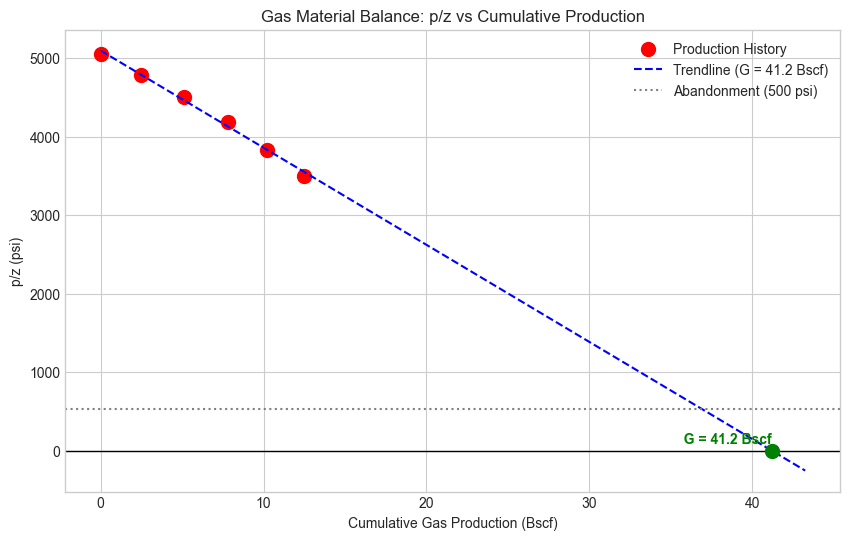

In [4]:
# Prepare Data for Regression
X = df['Gp_Bscf'].values.reshape(-1, 1)
y = df['p_over_z'].values

# Fit Linear Model
model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_

# Calculate Gas In Place (x-intercept)
# 0 = slope * G + intercept  ->  G = -intercept / slope
G_in_place = -intercept / slope

# Calculate Recovery Factor at Abandonment
# Assume Abandonment Pressure = 500 psi
P_abn = 500
z_abn = calculate_z_factor(P_abn, Temp_res, sg_gas)
pz_abn = P_abn / z_abn

# Gp at abandonment (Solve y = mx + c for x)
Gp_ultimate = (pz_abn - intercept) / slope
RF = Gp_ultimate / G_in_place * 100

print(f"--- RESULTS ---")
print(f"Initial p/z (pi/zi): {intercept:.1f} psi")
print(f"Slope (m):           {slope:.4f} psi/Bscf")
print(f"Original Gas in Place (G): {G_in_place:.2f} Bscf")
print(f"Reserves at 500 psi (Gp_ult): {Gp_ultimate:.2f} Bscf")
print(f"Recovery Factor:     {RF:.1f}%")

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

# 1. Plot History Data
plt.scatter(df['Gp_Bscf'], df['p_over_z'], color='red', s=100, label='Production History')

# 2. Plot Forecast Line (extrapolate to G)
x_forecast = np.linspace(0, G_in_place * 1.05, 100)
y_forecast = slope * x_forecast + intercept

plt.plot(x_forecast, y_forecast, 'b--', label=f'Trendline (G = {G_in_place:.1f} Bscf)')

# 3. Add Annotations
plt.axhline(0, color='black', linewidth=1)
plt.axhline(pz_abn, color='gray', linestyle=':', label=f'Abandonment ({P_abn} psi)')

# Highlight G point
plt.plot(G_in_place, 0, 'go', markersize=10)
plt.text(G_in_place, 100, f'  G = {G_in_place:.1f} Bscf', color='green', fontweight='bold', ha='right')

plt.xlabel('Cumulative Gas Production (Bscf)')
plt.ylabel('p/z (psi)')
plt.title('Gas Material Balance: p/z vs Cumulative Production')
plt.legend()
plt.grid(True)


plt.show()

## Conclusion

1.  **Linearity:** The points form a perfect straight line, confirming this is likely a **Volumetric Reservoir** (Closed Tank).
2.  **Estimation:** We successfully extrapolated the line to the x-axis to find the total volume of gas originally in the ground ($~32.5$ Bscf).
3.  **Future Use:** As more production data comes in (more red dots), we update this plot to reduce the uncertainty in the slope and refine our estimate of $G$.

**Diagnostic Note:**
* If the red dots started **curving upward** above the blue line, it would indicate **Water Influx** (pressure is staying higher than expected). In that case, this simple straight-line method calculates an *apparent* G that is too high, and we would need the full Havlena-Odeh method (Chapter 11).